In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from typing import Tuple, List, Optional, Dict, Union
import os
from pathlib import Path
import time

class HyperspectralClustering:
    """
    Class for unsupervised clustering of hyperspectral data and visualizing results.
    """

    def __init__(self, df: pd.DataFrame, image_shape: Optional[Tuple[int, int]] = None):
        """
        Initialize with the flattened hyperspectral dataframe.

        Args:
            df: DataFrame containing flattened hyperspectral data with x, y coordinates
            image_shape: Tuple of (height, width) of the original image. If None, inferred from data.
        """
        self.df = df

        # Extract spatial coordinates and feature columns
        self.x_col = 'x'
        self.y_col = 'y'

        # Validate that x and y columns exist
        if self.x_col not in df.columns or self.y_col not in df.columns:
            raise ValueError(f"DataFrame must contain '{self.x_col}' and '{self.y_col}' columns")

        # Get feature columns (all columns except x and y)
        self.feature_cols = [col for col in df.columns if col not in [self.x_col, self.y_col]]

        if len(self.feature_cols) == 0:
            raise ValueError("No feature columns found in DataFrame")

        print(f"Found {len(self.feature_cols)} feature columns in the data")

        # Determine image shape if not provided
        if image_shape is None:
            self.height = int(df[self.y_col].max()) + 1
            self.width = int(df[self.x_col].max()) + 1
        else:
            self.height, self.width = image_shape

        print(f"Image shape: {self.height} × {self.width} pixels")

        # Initialize model and results
        self.model = None
        self.labels = None
        self.feature_scaler = None
        self.scaled_features = None

    def preprocess(self, handle_nan: str = 'drop_feature'):
        """
        Preprocess the data for clustering.

        Args:
            handle_nan: Strategy for handling NaN values ('drop_feature', 'fill_zero', 'fill_mean')

        Returns:
            self: For method chaining
        """
        print("Preprocessing data...")

        # Extract features
        features = self.df[self.feature_cols].copy()

        # Count missing values
        nan_counts = features.isna().sum()
        nan_features = nan_counts[nan_counts > 0]

        if len(nan_features) > 0:
            print(f"Found {len(nan_features)} features with missing values")
            print(f"Top 5 features with most NaNs: {nan_features.sort_values(ascending=False).head()}")

            # Handle missing values based on strategy
            if handle_nan == 'drop_feature':
                # Drop features with any NaN values
                good_features = [col for col in self.feature_cols if nan_counts[col] == 0]
                features = self.df[good_features].copy()
                print(f"Dropped {len(self.feature_cols) - len(good_features)} features with NaNs")
                self.feature_cols = good_features

            elif handle_nan == 'fill_zero':
                # Replace NaN with zeros
                features.fillna(0, inplace=True)
                print("Filled NaN values with zeros")

            elif handle_nan == 'fill_mean':
                # Replace NaN with feature means
                features.fillna(features.mean(), inplace=True)
                print("Filled NaN values with feature means")

            else:
                raise ValueError(f"Unknown handle_nan strategy: {handle_nan}")

        # Scale the features
        self.feature_scaler = StandardScaler()
        self.scaled_features = self.feature_scaler.fit_transform(features)
        print(f"Scaled {self.scaled_features.shape[1]} features")

        return self

    def find_optimal_clusters(self, max_clusters: int = 10, random_state: int = 42):
        """
        Find the optimal number of clusters using silhouette score and inertia.

        Args:
            max_clusters: Maximum number of clusters to try
            random_state: Random seed for reproducibility

        Returns:
            Tuple of (silhouette_scores, inertia_values)
        """
        print(f"Finding optimal number of clusters (max={max_clusters})...")

        # Ensure data is preprocessed
        if self.scaled_features is None:
            self.preprocess()

        # Try different numbers of clusters
        silhouette_scores = []
        inertia_values = []

        # Start from 2 clusters (silhouette score requires at least 2)
        for n_clusters in range(2, max_clusters + 1):
            start_time = time.time()

            # Fit KMeans
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
            cluster_labels = kmeans.fit_predict(self.scaled_features)

            # Calculate metrics
            silhouette_avg = silhouette_score(self.scaled_features, cluster_labels)
            inertia = kmeans.inertia_

            silhouette_scores.append(silhouette_avg)
            inertia_values.append(inertia)

            duration = time.time() - start_time
            print(f"  {n_clusters} clusters: silhouette={silhouette_avg:.4f}, inertia={inertia:.4f} (took {duration:.2f}s)")

        return silhouette_scores, inertia_values

    def plot_cluster_metrics(self,
                             silhouette_scores: List[float],
                             inertia_values: List[float],
                             max_clusters: int = 10):
        """
        Plot metrics to help select the optimal number of clusters.

        Args:
            silhouette_scores: List of silhouette scores for different numbers of clusters
            inertia_values: List of inertia values for different numbers of clusters
            max_clusters: Maximum number of clusters tried

        Returns:
            Matplotlib figure
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot silhouette scores
        cluster_range = range(2, max_clusters + 1)
        ax1.plot(cluster_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Score vs Number of Clusters')
        ax1.grid(True, alpha=0.3)

        # Find optimal according to silhouette
        optimal_idx = np.argmax(silhouette_scores)
        optimal_clusters = cluster_range[optimal_idx]
        ax1.axvline(x=optimal_clusters, color='r', linestyle='--',
                   label=f'Optimal: {optimal_clusters} clusters')
        ax1.legend()

        # Plot inertia (elbow method)
        ax2.plot(cluster_range, inertia_values, 'o-', linewidth=2, markersize=8)
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Inertia')
        ax2.set_title('Inertia vs Number of Clusters (Elbow Method)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        return fig

    def fit_kmeans(self, n_clusters: int = 5, random_state: int = 42):
        """
        Fit K-means clustering on the hyperspectral data.

        Args:
            n_clusters: Number of clusters
            random_state: Random seed for reproducibility

        Returns:
            self: For method chaining
        """
        print(f"Fitting K-means with {n_clusters} clusters...")

        # Ensure data is preprocessed
        if self.scaled_features is None:
            self.preprocess()

        # Fit the model
        self.model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        self.labels = self.model.fit_predict(self.scaled_features)

        # Add cluster labels to dataframe
        self.df['cluster'] = self.labels

        # Calculate cluster sizes
        cluster_sizes = np.bincount(self.labels)

        print("Cluster sizes:")
        for i, size in enumerate(cluster_sizes):
            percentage = size / len(self.labels) * 100
            print(f"  Cluster {i}: {size} pixels ({percentage:.2f}%)")

        return self

    def reconstruct_cluster_image(self) -> np.ndarray:
        """
        Reconstruct the cluster assignments into the original image shape.

        Returns:
            2D array of cluster assignments with shape (height, width)
        """
        if self.labels is None:
            raise ValueError("Must fit a model first using fit_kmeans()")

        # Create empty image array
        cluster_image = np.full((self.height, self.width), -1, dtype=int)

        # Fill in cluster assignments
        for idx, row in self.df.iterrows():
            x, y = int(row[self.x_col]), int(row[self.y_col])
            if 0 <= x < self.width and 0 <= y < self.height:
                cluster_image[y, x] = row['cluster']

        return cluster_image

    def visualize_clusters(self,
                          figsize: Tuple[int, int] = (12, 10),
                          cmap: Optional[Union[str, ListedColormap]] = None,
                          save_path: Optional[str] = None) -> plt.Figure:
        """
        Visualize the clustering results by reconstructing the original image.

        Args:
            figsize: Figure size
            cmap: Colormap to use for visualization
            save_path: Path to save the visualization image

        Returns:
            Matplotlib figure
        """
        if self.labels is None:
            raise ValueError("Must fit a model first using fit_kmeans()")

        # Reconstruct cluster image
        cluster_image = self.reconstruct_cluster_image()
        n_clusters = len(np.unique(self.labels))

        # Create a good colormap for the number of clusters
        if cmap is None:
            # Choose colormap based on number of clusters
            if n_clusters <= 10:
                # For few clusters, use distinct colors
                # Get a good set of distinct colors
                tableau_colors = list(mcolors.TABLEAU_COLORS.values())
                color_list = tableau_colors[:n_clusters]
                cmap = ListedColormap(color_list)
            else:
                # For many clusters, use a continuous colormap
                cmap = 'tab20' if n_clusters <= 20 else 'viridis'

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Display the image
        im = ax.imshow(cluster_image, cmap=cmap)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Cluster')

        # Set title and labels
        ax.set_title(f'K-means Clustering Results ({n_clusters} clusters)')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

        # Save figure if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved cluster visualization to {save_path}")

        return fig

    def visualize_separate_clusters(self,
                                   figsize: Tuple[int, int] = (15, 10),
                                   cmap: str = 'viridis',
                                   n_cols: int = 3,
                                   save_path: Optional[str] = None) -> plt.Figure:
        """
        Visualize each cluster separately.

        Args:
            figsize: Figure size
            cmap: Colormap to use for visualization
            n_cols: Number of columns in the subplot grid
            save_path: Path to save the visualization image

        Returns:
            Matplotlib figure
        """
        if self.labels is None:
            raise ValueError("Must fit a model first using fit_kmeans()")

        # Reconstruct cluster image
        cluster_image = self.reconstruct_cluster_image()
        n_clusters = len(np.unique(self.labels))

        # Set up subplot grid
        n_rows = (n_clusters + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()

        # Create separate mask for each cluster
        for i in range(n_clusters):
            ax = axes[i]

            # Create binary mask for this cluster
            mask = (cluster_image == i).astype(float)

            # Display the mask
            im = ax.imshow(mask, cmap=cmap)

            # Set title and turn off axis labels
            ax.set_title(f'Cluster {i}')
            ax.set_xticks([])
            ax.set_yticks([])

            # Add colorbar
            plt.colorbar(im, ax=ax)

        # Turn off any unused subplots
        for i in range(n_clusters, len(axes)):
            axes[i].axis('off')

        # Add overall title
        fig.suptitle('Individual Clusters', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle

        # Save figure if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved individual cluster visualization to {save_path}")

        return fig

    def visualize_cluster_spectra(self,
                                 excitations: Optional[List[float]] = None,
                                 figsize: Tuple[int, int] = (15, 10),
                                 save_path: Optional[str] = None) -> plt.Figure:
        """
        Visualize the average spectra for each cluster.

        Args:
            excitations: List of excitation wavelengths to include (if None, use all)
            figsize: Figure size
            save_path: Path to save the visualization image

        Returns:
            Matplotlib figure
        """
        if self.labels is None:
            raise ValueError("Must fit a model first using fit_kmeans()")

        # Get all feature columns that have the format "emission-excitation"
        spectral_cols = [col for col in self.feature_cols if '-' in col]

        # If no spectral columns, we can't visualize spectra
        if not spectral_cols:
            raise ValueError("No spectral columns found in DataFrame")

        # Parse excitation and emission wavelengths from column names
        wavelengths = []
        for col in spectral_cols:
            try:
                emission, excitation = map(float, col.split('-'))
                wavelengths.append((emission, excitation, col))
            except ValueError:
                print(f"Skipping column {col} - doesn't match expected format")

        # Filter by excitation wavelengths if requested
        if excitations:
            wavelengths = [(em, ex, col) for em, ex, col in wavelengths if ex in excitations]

        # If no wavelengths left, we can't visualize spectra
        if not wavelengths:
            raise ValueError("No valid spectral columns found after filtering")

        # Group by excitation wavelength
        excitations = sorted(set(ex for _, ex, _ in wavelengths))

        # Set up subplot grid
        n_rows = min(3, len(excitations))
        n_cols = (len(excitations) + n_rows - 1) // n_rows
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axes = axes.flatten()

        # Get number of clusters
        n_clusters = len(np.unique(self.labels))

        # Set up colors for clusters
        colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

        # Plot spectra for each excitation wavelength
        for ax_idx, excitation in enumerate(excitations):
            if ax_idx < len(axes):
                ax = axes[ax_idx]

                # Get emission wavelengths and column names for this excitation
                excitation_data = [(em, col) for em, ex, col in wavelengths if ex == excitation]

                if excitation_data:
                    # Sort by emission wavelength
                    excitation_data.sort()
                    emission_wavelengths = [em for em, _ in excitation_data]
                    columns = [col for _, col in excitation_data]

                    # Plot average spectrum for each cluster
                    for cluster_idx in range(n_clusters):
                        # Get cluster data
                        cluster_data = self.df[self.df['cluster'] == cluster_idx]

                        # Calculate mean spectrum for this cluster
                        mean_spectrum = cluster_data[columns].mean().values

                        # Plot spectrum
                        ax.plot(emission_wavelengths, mean_spectrum, '-',
                                color=colors[cluster_idx], linewidth=2,
                                label=f'Cluster {cluster_idx}')

                    # Set labels and title
                    ax.set_xlabel('Emission Wavelength (nm)')
                    ax.set_ylabel('Mean Intensity')
                    ax.set_title(f'Excitation {excitation} nm')
                    ax.grid(True, alpha=0.3)

                    # Add legend to first plot only
                    if ax_idx == 0:
                        ax.legend(loc='best')

        # Turn off any unused subplots
        for i in range(len(excitations), len(axes)):
            axes[i].axis('off')

        # Add overall title
        fig.suptitle('Average Spectra by Cluster', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle

        # Save figure if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved cluster spectra visualization to {save_path}")

        return fig

    def save_cluster_results(self, output_file: str):
        """
        Save clustering results to a file.

        Args:
            output_file: Path to save the results
        """
        if self.labels is None:
            raise ValueError("Must fit a model first using fit_kmeans()")

        # Create output directory if it doesn't exist
        output_dir = os.path.dirname(output_file)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Get file extension
        _, ext = os.path.splitext(output_file)

        # Save based on file type
        if ext.lower() in ['.csv']:
            # Save to CSV (coordinates and cluster assignments only)
            result_df = self.df[[self.x_col, self.y_col, 'cluster']].copy()
            result_df.to_csv(output_file, index=False)
            print(f"Saved cluster assignments to {output_file}")

        elif ext.lower() in ['.pkl', '.pickle']:
            # Save full DataFrame with cluster assignments
            self.df.to_pickle(output_file)
            print(f"Saved full DataFrame with clusters to {output_file}")

        elif ext.lower() in ['.parquet']:
            # Save full DataFrame with cluster assignments
            self.df.to_parquet(output_file)
            print(f"Saved full DataFrame with clusters to {output_file}")

        else:
            # Default to CSV
            result_df = self.df[[self.x_col, self.y_col, 'cluster']].copy()
            result_df.to_csv(output_file, index=False)
            print(f"Saved cluster assignments to {output_file}")

def run_kmeans_clustering(
    input_file: str,
    n_clusters: Optional[int] = None,
    max_clusters: int = 10,
    output_dir: Optional[str] = None,
    random_state: int = 42
):
    """
    Run K-means clustering on hyperspectral data and save results.

    Args:
        input_file: Path to input CSV/parquet/pickle file with flattened hyperspectral data
        n_clusters: Number of clusters to use (if None, determine automatically)
        max_clusters: Maximum number of clusters to try if determining automatically
        output_dir: Directory to save outputs (if None, use same directory as input)
        random_state: Random seed for reproducibility
    """
    # Determine file type and load data
    _, ext = os.path.splitext(input_file)

    print(f"Loading data from {input_file}...")
    if ext.lower() in ['.csv']:
        df = pd.read_csv(input_file)
    elif ext.lower() in ['.pkl', '.pickle']:
        df = pd.read_pickle(input_file)
    elif ext.lower() in ['.parquet']:
        df = pd.read_parquet(input_file)
    else:
        raise ValueError(f"Unsupported file type: {ext}")

    print(f"Loaded dataframe with {len(df)} rows and {len(df.columns)} columns")

    # Set up output directory
    if output_dir is None:
        output_dir = os.path.dirname(input_file)
        if not output_dir:
            output_dir = "."

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get base filename without extension
    base_name = os.path.basename(input_file)
    base_name = os.path.splitext(base_name)[0]

    # Initialize clustering
    clustering = HyperspectralClustering(df)

    # Preprocess the data
    clustering.preprocess()

    # If number of clusters not specified, find optimal
    if n_clusters is None:
        silhouette_scores, inertia_values = clustering.find_optimal_clusters(max_clusters, random_state)

        # Plot metrics
        fig = clustering.plot_cluster_metrics(silhouette_scores, inertia_values, max_clusters)
        metrics_path = os.path.join(output_dir, f"{base_name}_cluster_metrics.png")
        fig.savefig(metrics_path, dpi=300, bbox_inches='tight')
        print(f"Saved cluster metrics plot to {metrics_path}")

        # Choose optimal number of clusters (highest silhouette score)
        n_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because we start from 2 clusters
        print(f"Selected optimal number of clusters: {n_clusters}")

    # Fit K-means with the chosen number of clusters
    clustering.fit_kmeans(n_clusters, random_state)

    # Visualize clustering results
    fig = clustering.visualize_clusters()
    clusters_path = os.path.join(output_dir, f"{base_name}_kmeans_clusters.png")
    fig.savefig(clusters_path, dpi=300, bbox_inches='tight')
    print(f"Saved cluster visualization to {clusters_path}")

    # Visualize individual clusters
    fig = clustering.visualize_separate_clusters()
    separate_path = os.path.join(output_dir, f"{base_name}_separate_clusters.png")
    fig.savefig(separate_path, dpi=300, bbox_inches='tight')
    print(f"Saved individual cluster visualization to {separate_path}")

    # Visualize cluster spectra
    try:
        fig = clustering.visualize_cluster_spectra()
        spectra_path = os.path.join(output_dir, f"{base_name}_cluster_spectra.png")
        fig.savefig(spectra_path, dpi=300, bbox_inches='tight')
        print(f"Saved cluster spectra visualization to {spectra_path}")
    except ValueError as e:
        print(f"Could not visualize cluster spectra: {e}")

    # Save cluster results
    results_path = os.path.join(output_dir, f"{base_name}_kmeans_results.csv")
    clustering.save_cluster_results(results_path)

    print("K-means clustering complete!")

Loading data from ../Data/Kiwi Experiment/parquests/KiwiDataMasked.parquet...
Loaded dataframe with 1179766 rows and 564 columns
Found 562 feature columns in the data
Image shape: 1022 × 1352 pixels
Preprocessing data...
Scaled 562 features
Fitting K-means with 3 clusters...
Cluster sizes:
  Cluster 0: 693598 pixels (58.79%)
  Cluster 1: 66106 pixels (5.60%)
  Cluster 2: 420062 pixels (35.61%)
Saved cluster visualization to KMeansResults/Masked/N-Clusters3\KiwiDataMasked_kmeans_clusters.png
Saved individual cluster visualization to KMeansResults/Masked/N-Clusters3\KiwiDataMasked_separate_clusters.png
Saved cluster spectra visualization to KMeansResults/Masked/N-Clusters3\KiwiDataMasked_cluster_spectra.png
Saved cluster assignments to KMeansResults/Masked/N-Clusters3\KiwiDataMasked_kmeans_results.csv
K-means clustering complete!
Loading data from ../Data/Kiwi Experiment/parquests/KiwiDataMasked.parquet...
Loaded dataframe with 1179766 rows and 564 columns
Found 562 feature columns in th

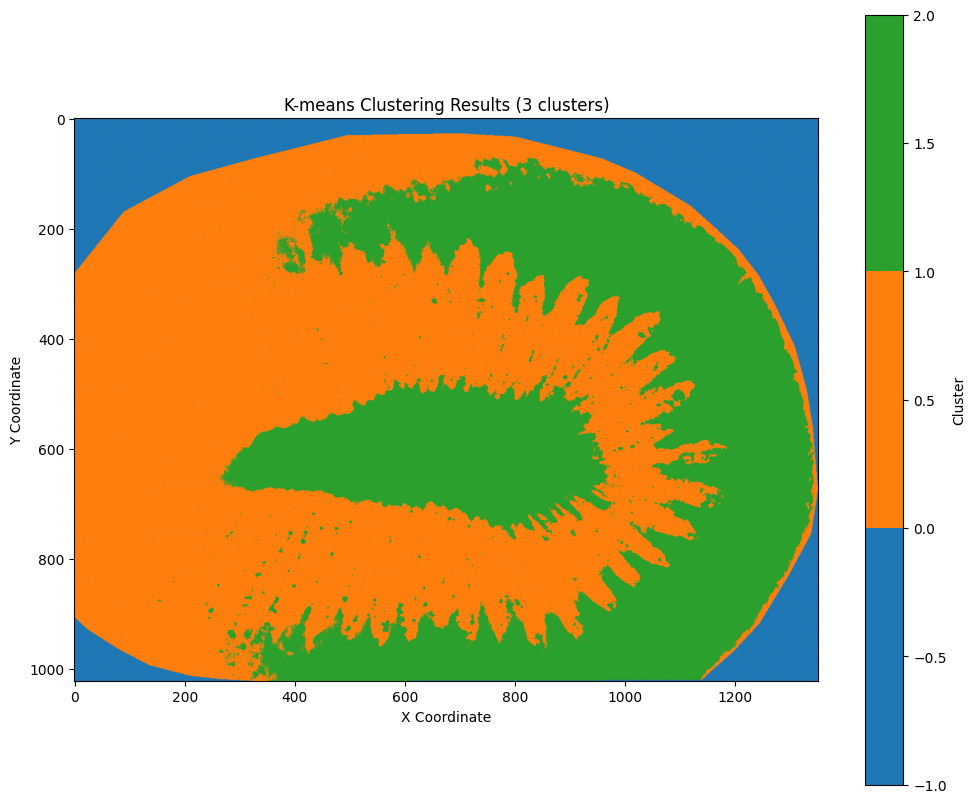

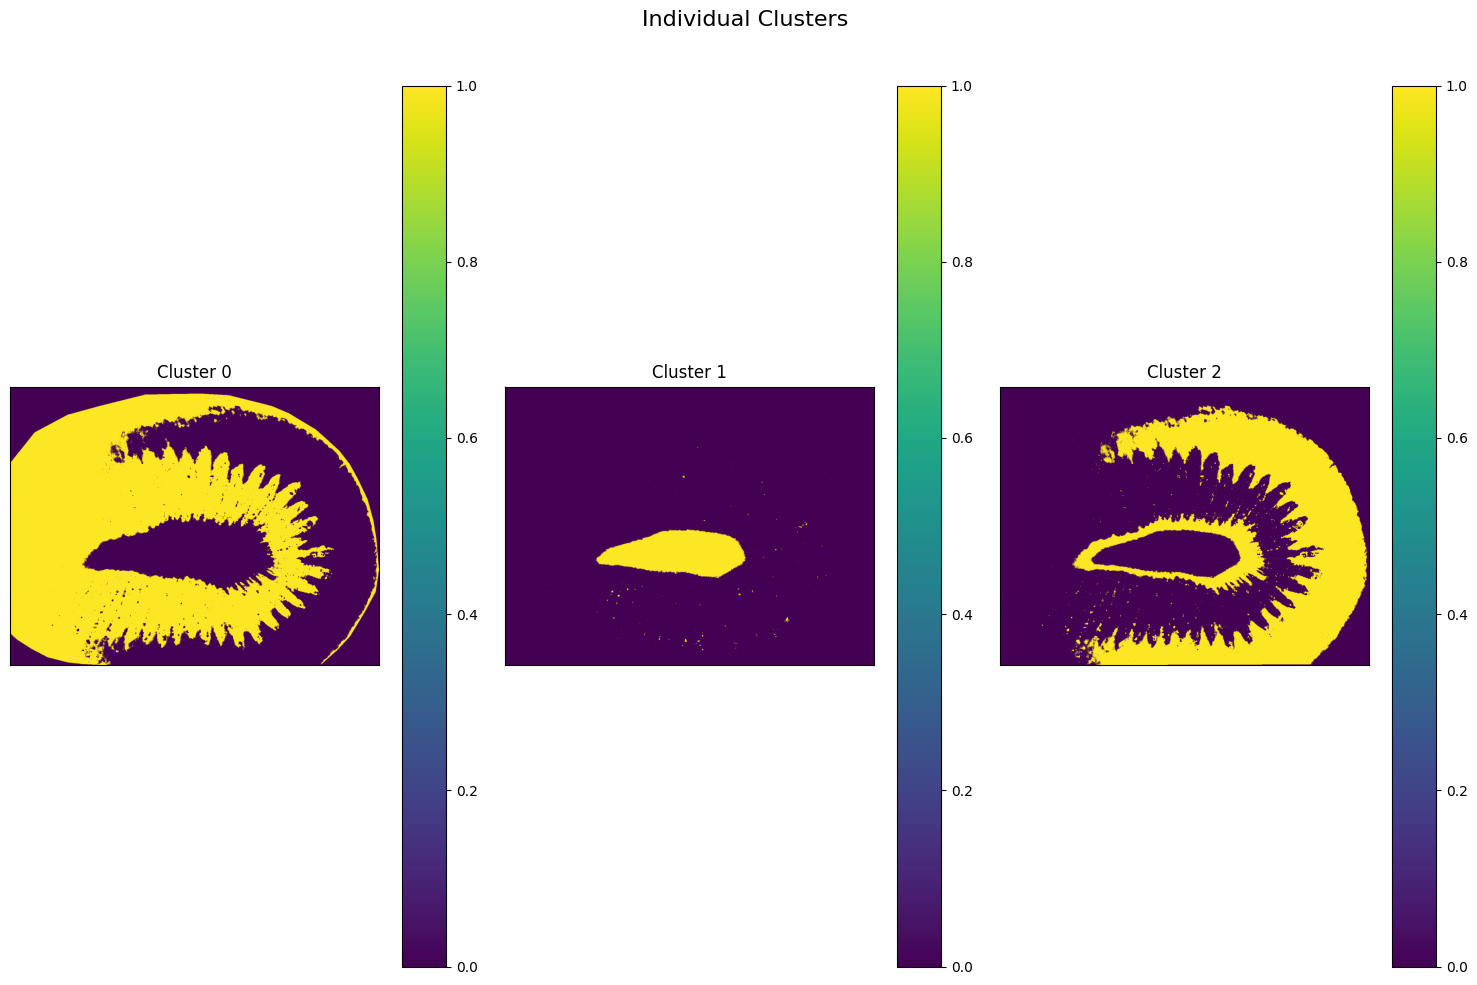

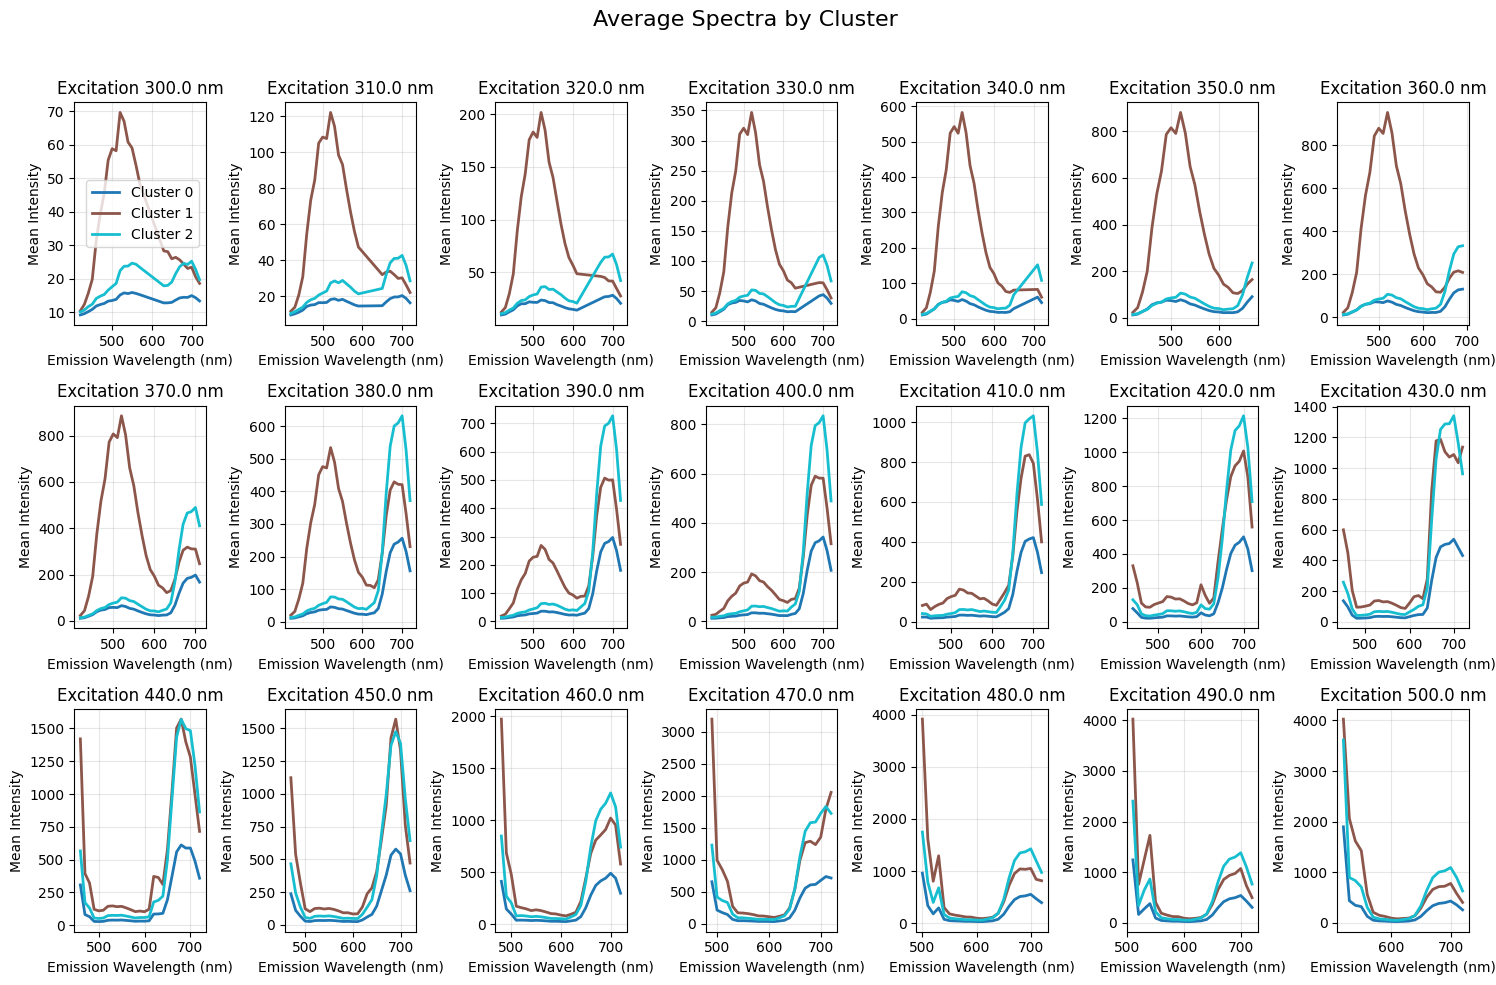

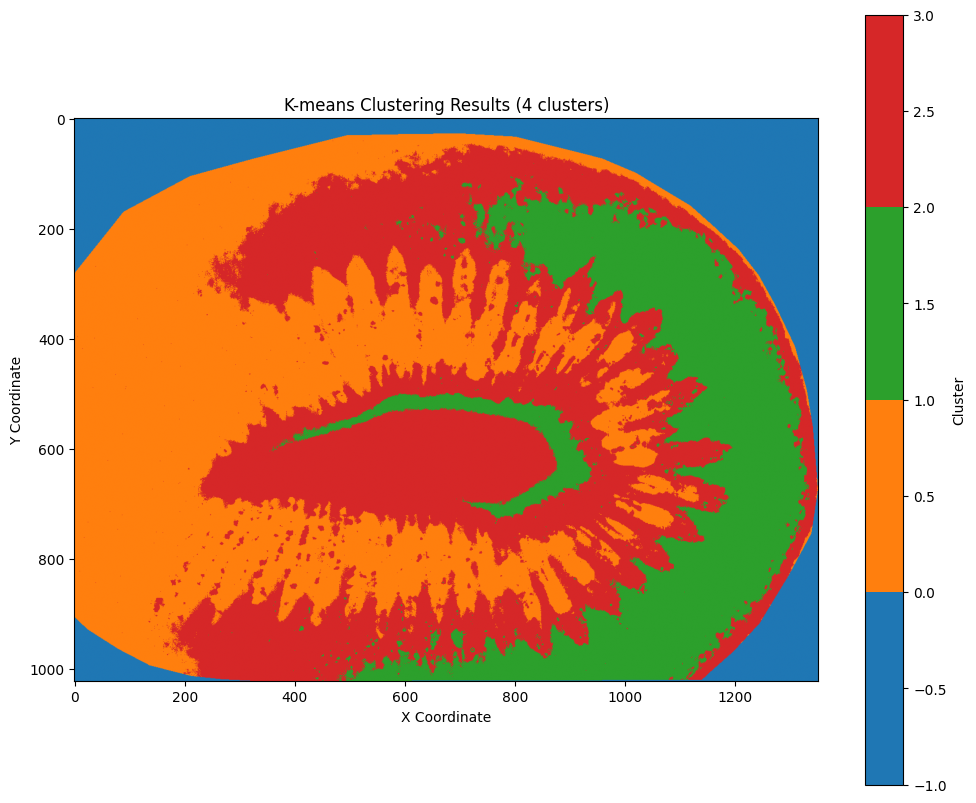

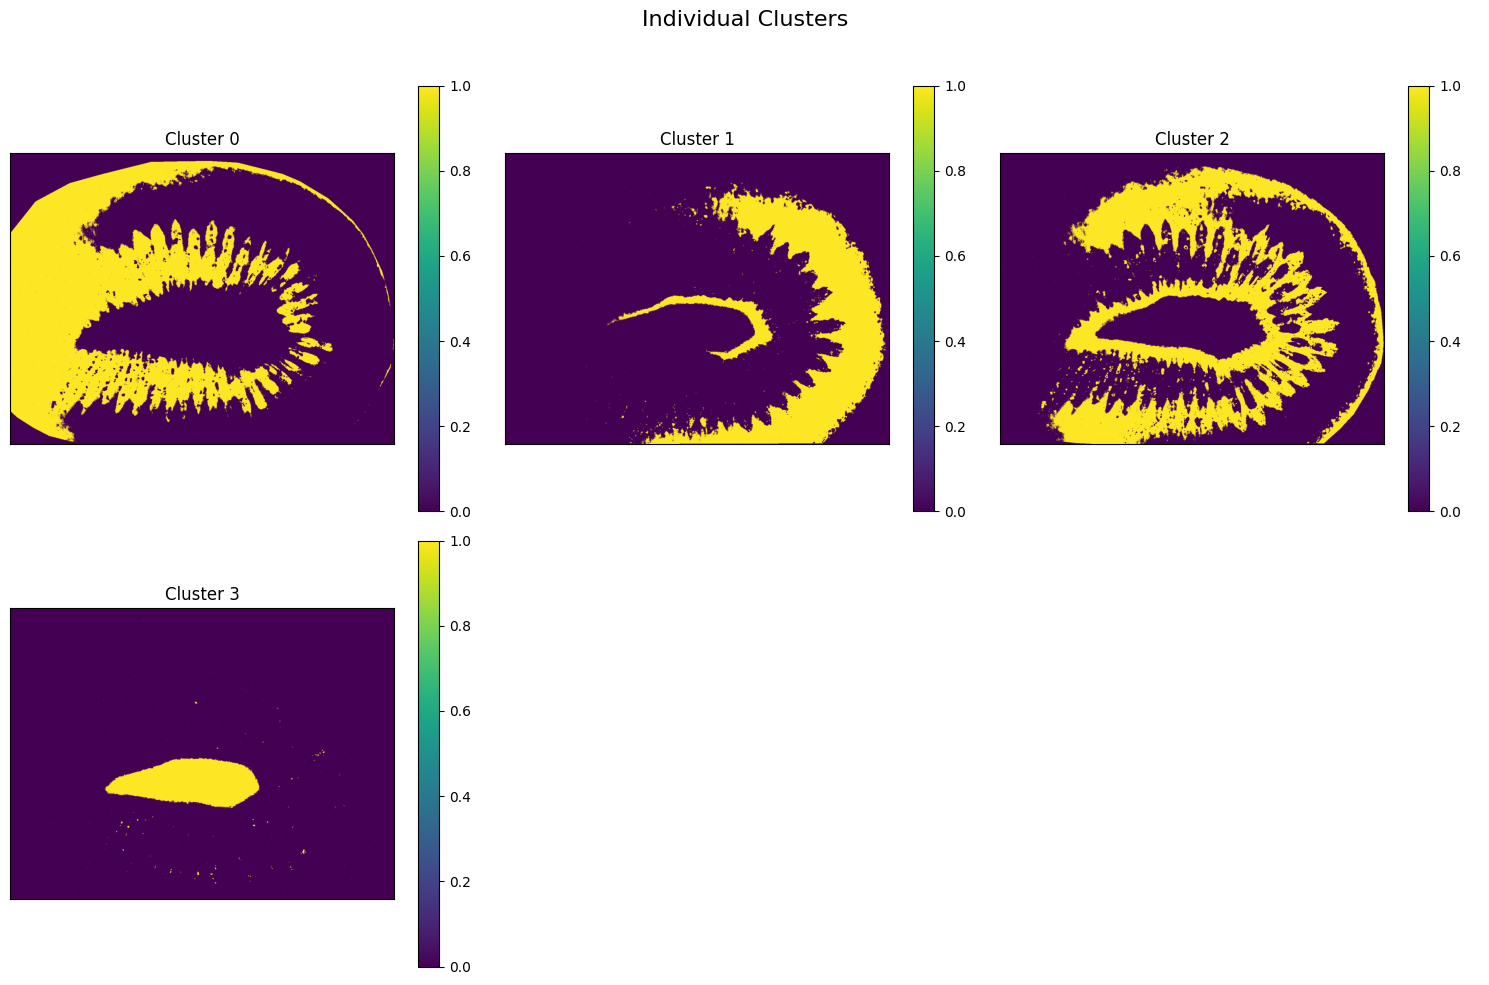

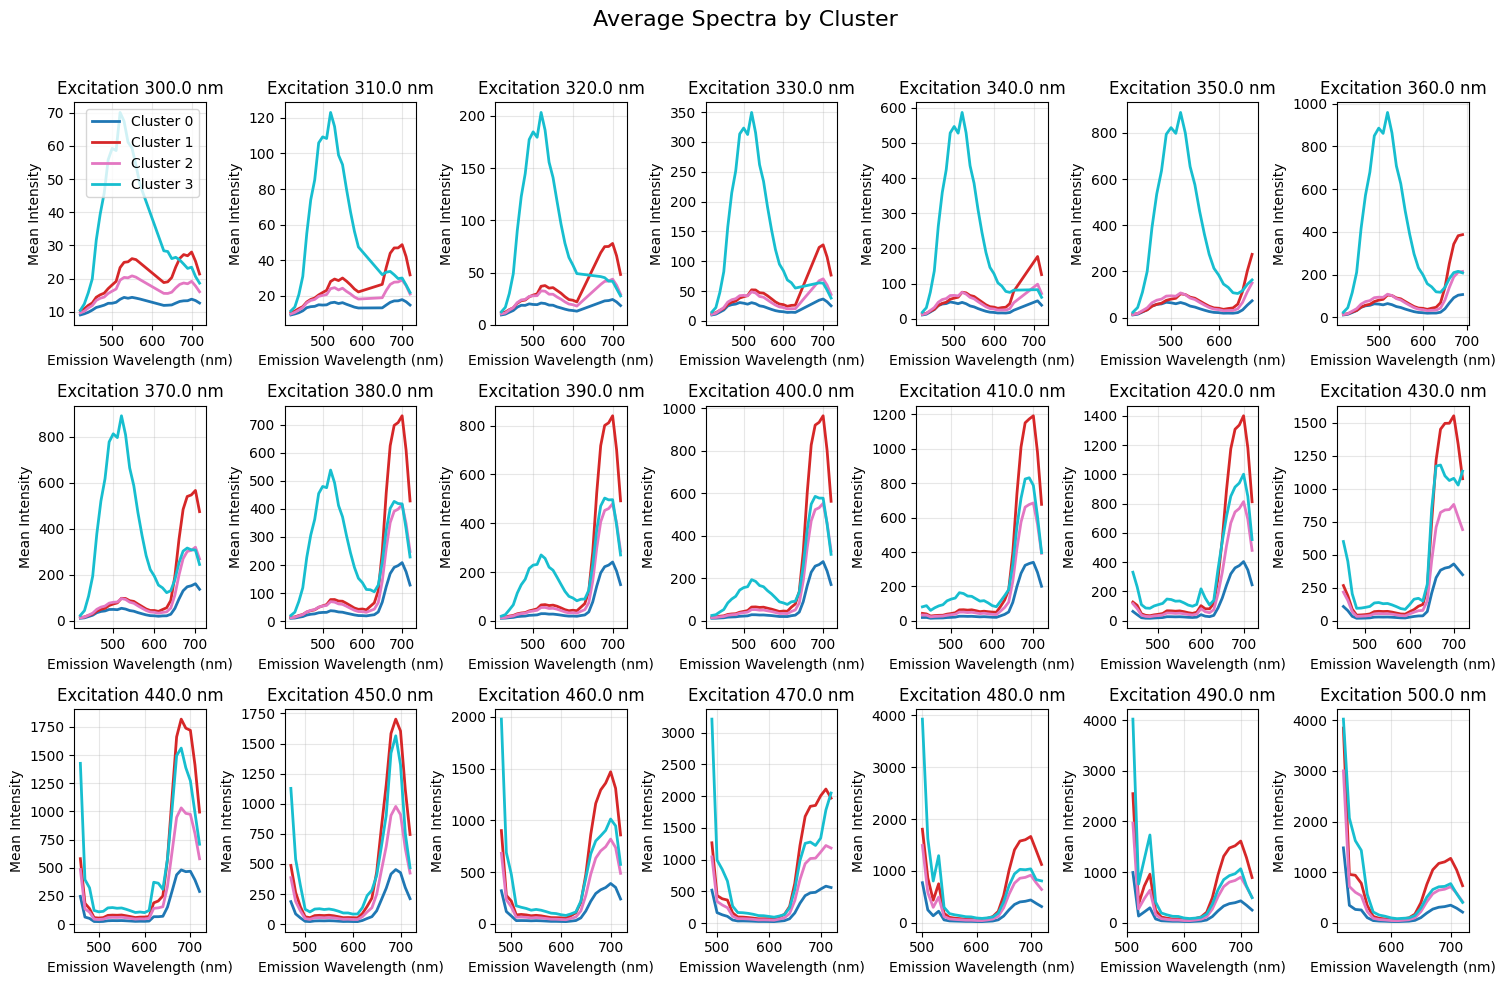

In [2]:
for i in range(3, 5):
    run_kmeans_clustering("../Data/Kiwi Experiment/parquests/KiwiDataMasked.parquet", n_clusters=i, output_dir=f"KMeansResults/Masked/N-Clusters{i}")

Loading data from ../Data/Kiwi Experiment/parquests/KiwiDataMaskedUpNormalized.parquet...
Loaded dataframe with 1179766 rows and 564 columns
Found 562 feature columns in the data
Image shape: 1022 × 1352 pixels
Preprocessing data...
Scaled 562 features
Fitting K-means with 3 clusters...
Cluster sizes:
  Cluster 0: 693598 pixels (58.79%)
  Cluster 1: 66106 pixels (5.60%)
  Cluster 2: 420062 pixels (35.61%)
Saved cluster visualization to KMeansResults/MaskedUpNormalized/N-Clusters3\KiwiDataMaskedUpNormalized_kmeans_clusters.png
Saved individual cluster visualization to KMeansResults/MaskedUpNormalized/N-Clusters3\KiwiDataMaskedUpNormalized_separate_clusters.png
Saved cluster spectra visualization to KMeansResults/MaskedUpNormalized/N-Clusters3\KiwiDataMaskedUpNormalized_cluster_spectra.png
Saved cluster assignments to KMeansResults/MaskedUpNormalized/N-Clusters3\KiwiDataMaskedUpNormalized_kmeans_results.csv
K-means clustering complete!
Loading data from ../Data/Kiwi Experiment/parquests/

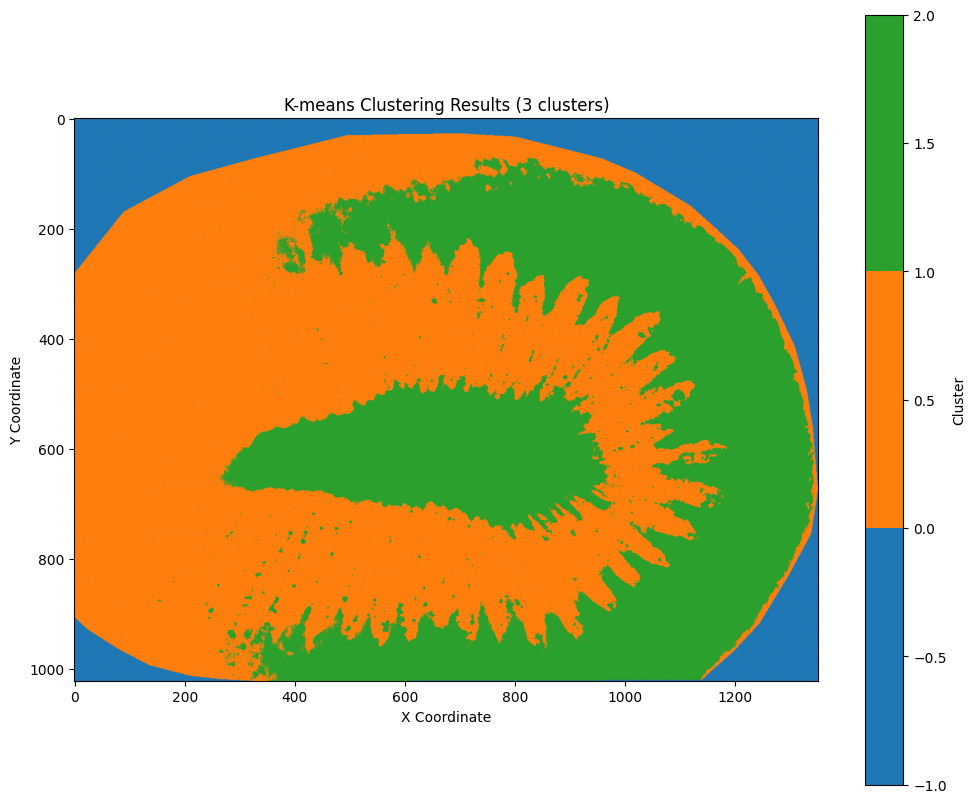

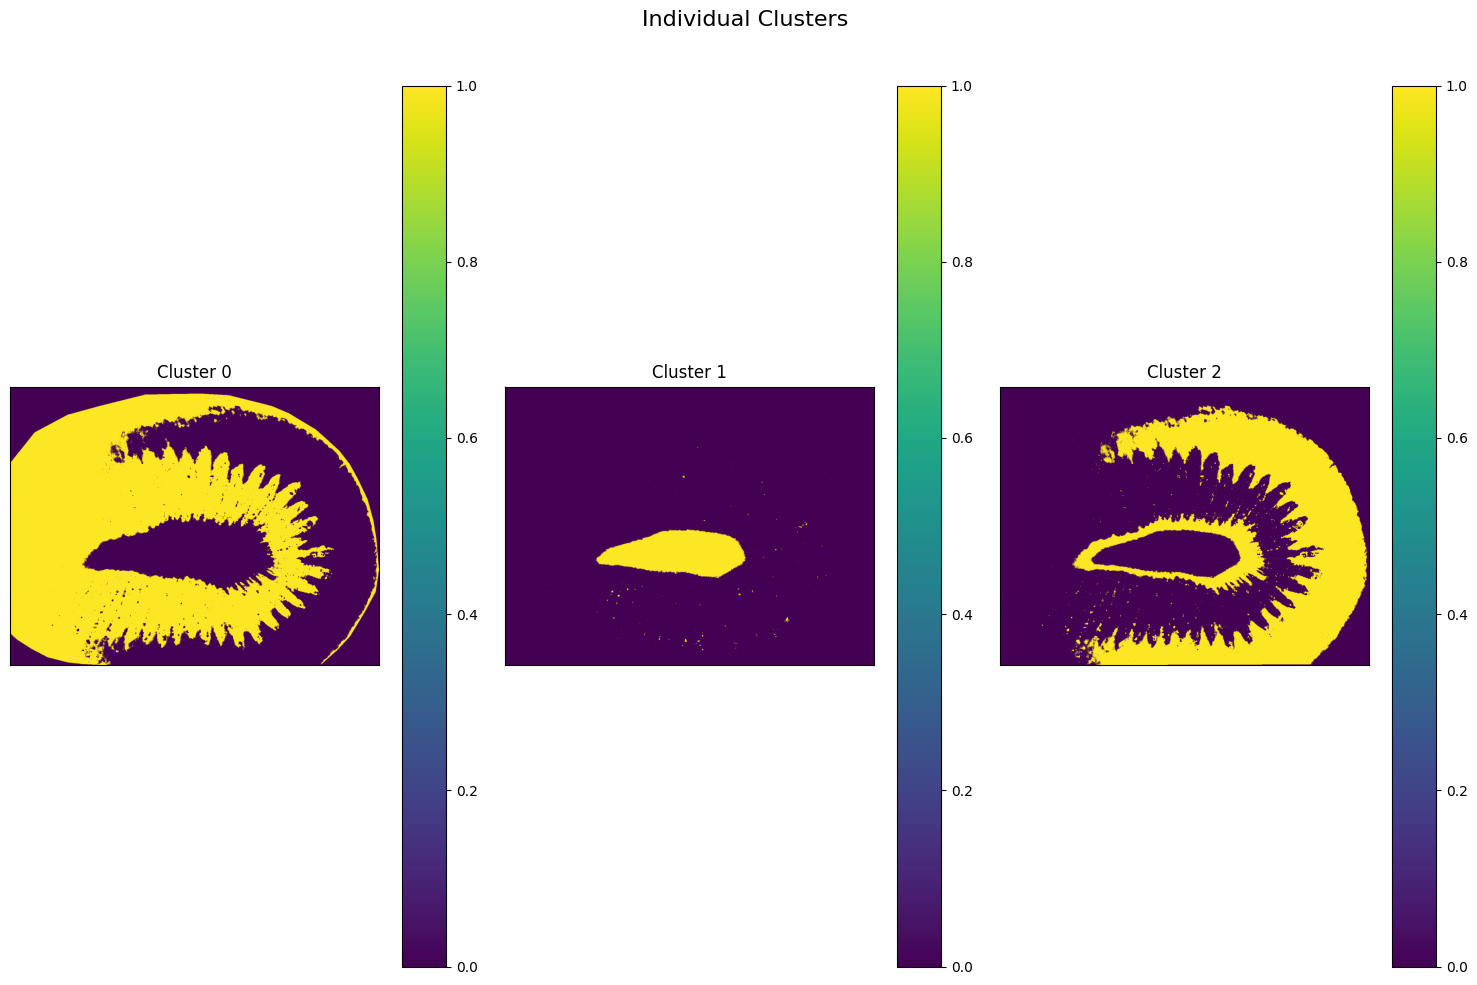

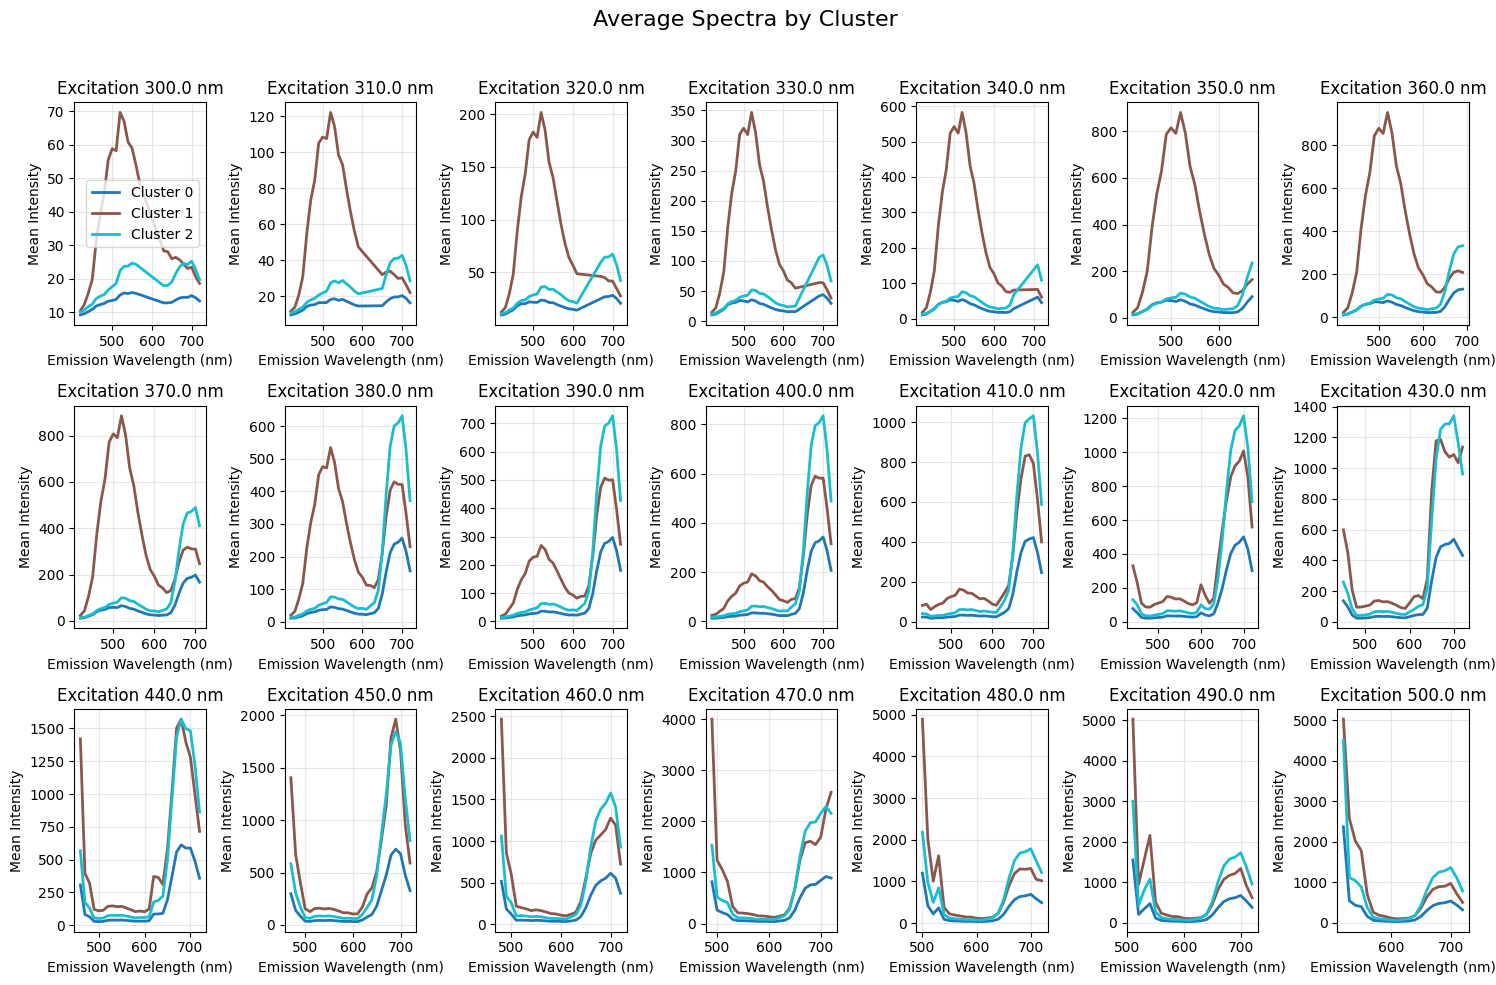

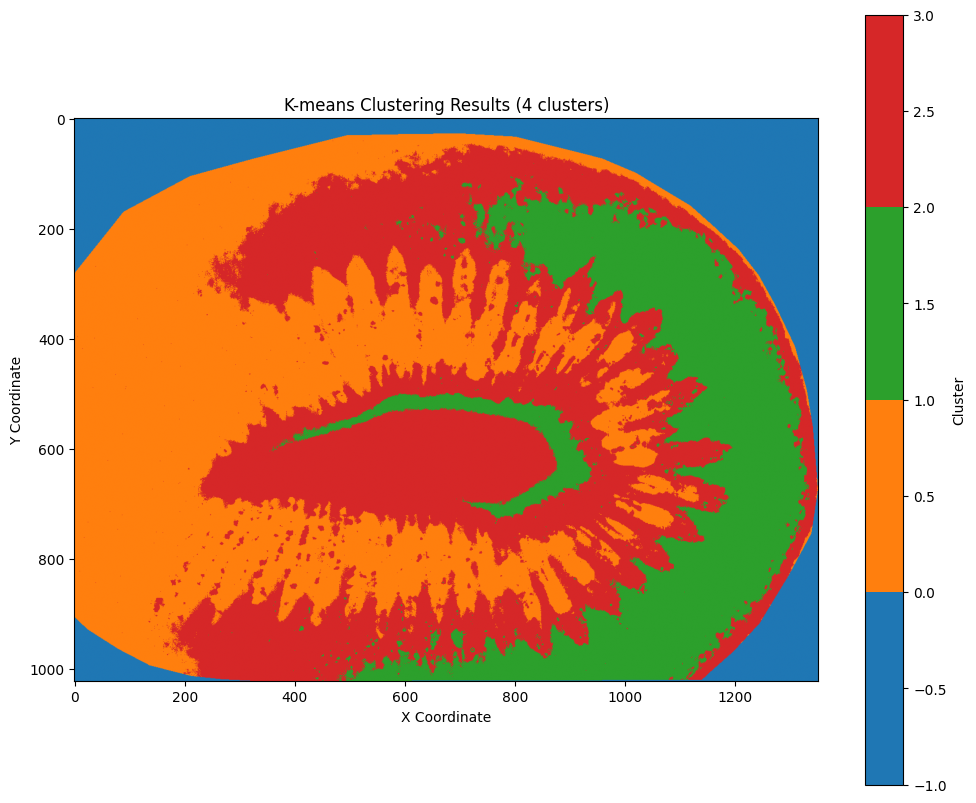

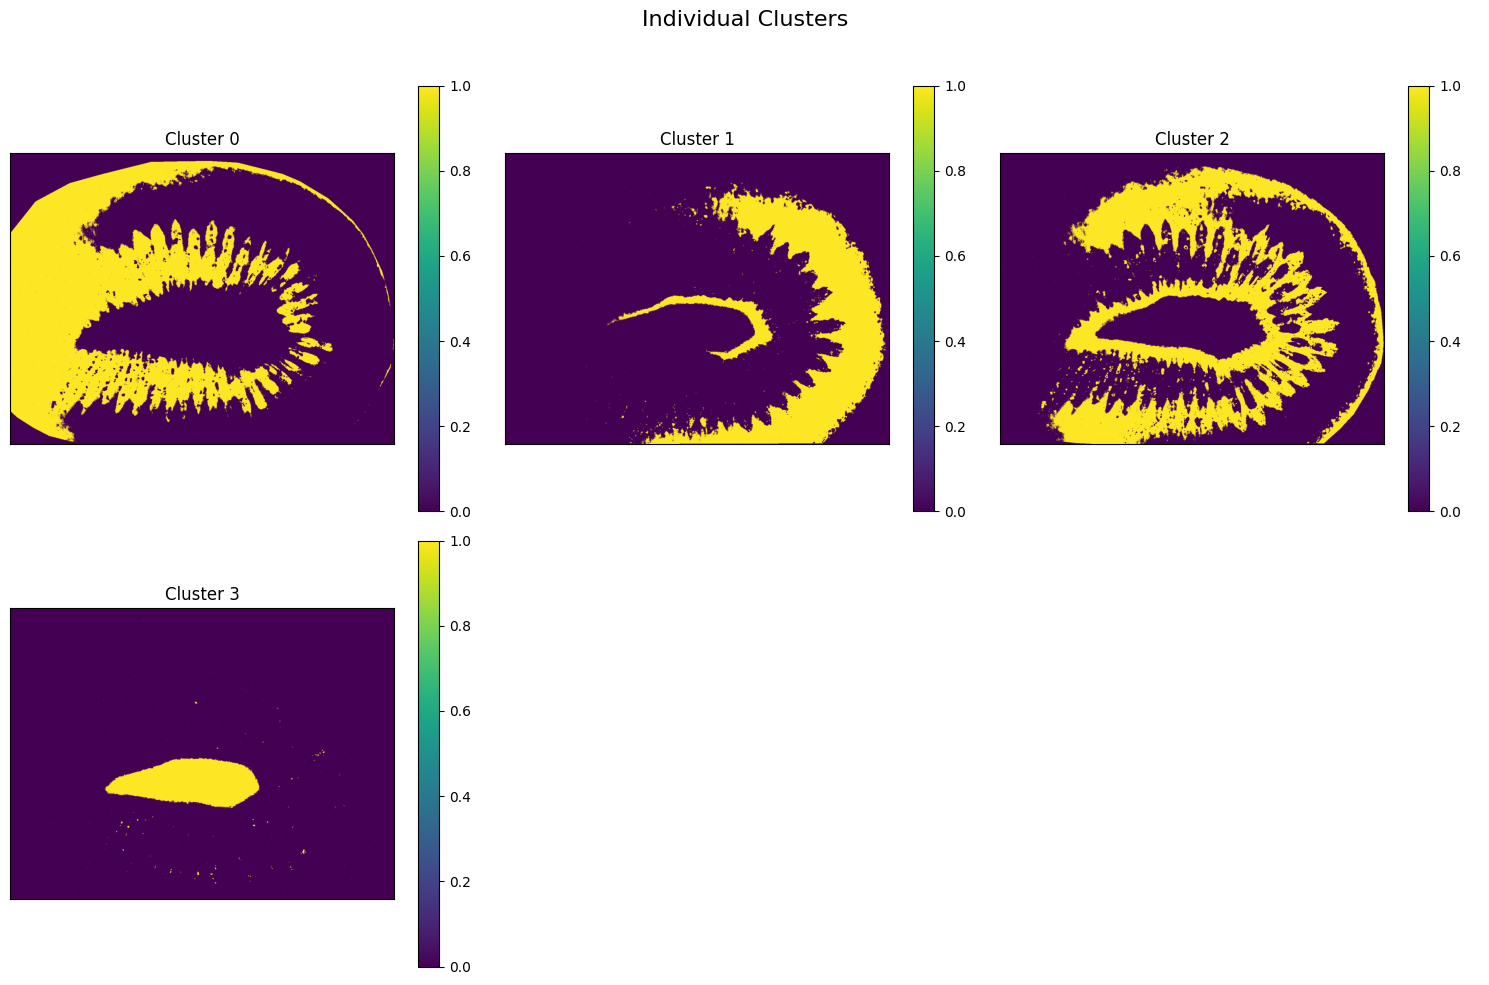

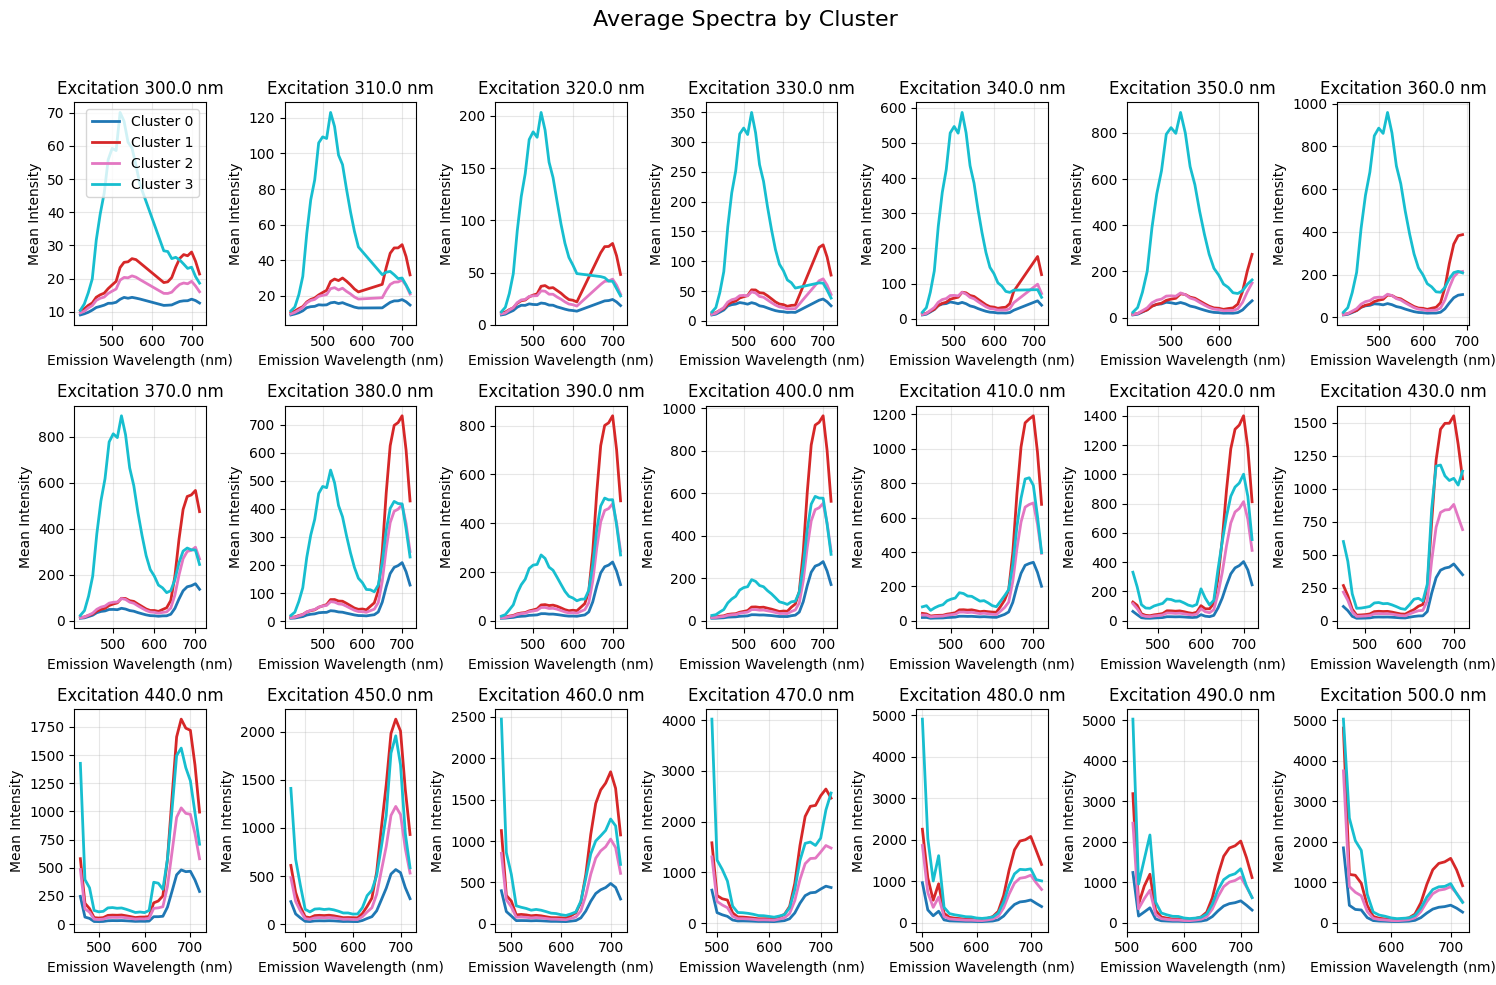

In [3]:
for i in range(3, 5):
    run_kmeans_clustering("../Data/Kiwi Experiment/parquests/KiwiDataMaskedUpNormalized.parquet", n_clusters=i, output_dir=f"KMeansResults/MaskedUpNormalized/N-Clusters{i}")